# DNSC 6211-01 Group Project
# Trip Advisor - Romance tour of Las Vegas
**Group 4:**
* Ziyi Zhao
* Jingze Zhang
* Erya Ouyang
* Agnes Jiang
* Huiting Tang

Video link:  
https://www.youtube.com/watch?v=ZP-9qu0ubHg&feature=youtu.be

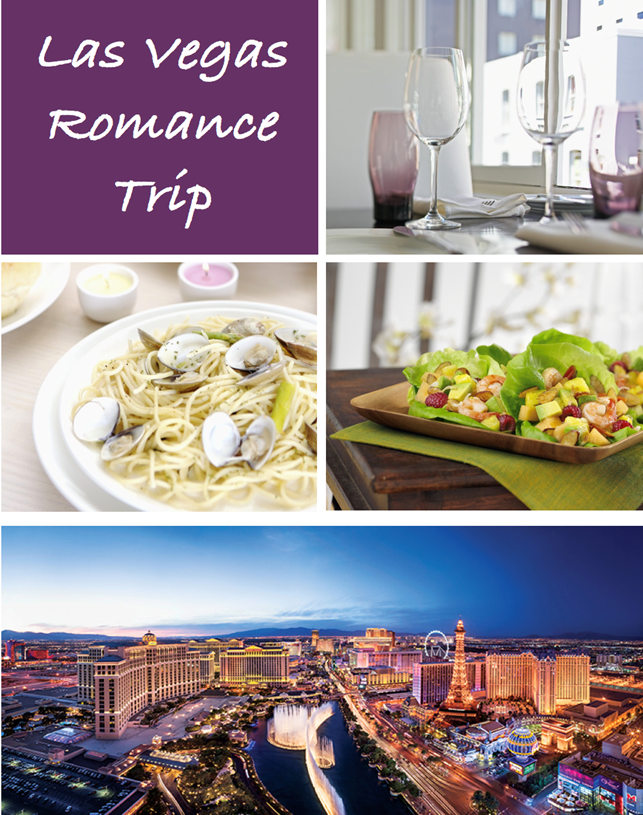

## Part 1: Data preparation

### Workflow
#### In order to run  all the codes smoothly, please make sure you first import the yelp_db.sql file into MySQL through MySQL workbench. 
#### You also need to have word cloud package (https://github.com/amueller/word_cloud) and gmplot package (https://github.com/vgm64/gmplot).
#### Make sure these pictures are in the same folder with the notebook. 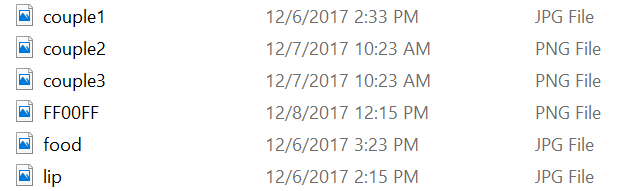

In [1]:
import pymysql as myDB
import csv
import pandas as pd
import pandas.io.sql as pdSQL

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
plt.style.use('ggplot')

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import random

### Connect to local MySQL database

In [2]:
#Please modify the following information with your local MySQL server
host = "localhost"
user = "root"
password = "root"
database = "yelp_db"
dbcon = myDB.connect(host=host,user=user,passwd=password,db=database)

### Split the column date in checkin table to checkin_day and checkin_time

In [3]:
#This will take some time
sql = '''
ALTER TABLE checkin;
ADD checkin_day TEXT,
ADD checkin_time TEXT;

UPDATE checkin
SET checkin_day = substr(date, 1, instr(date,'-') - 1),
    checkin_time = substr(date, instr(date, '-') + 1)
WHERE checkin.date LIKE '%-%';

ALTER TABLE checkin DROP date;
'''

cursor = dbcon.cursor()
cursor.execute(sql)

## Part 2: Recommendations by categories

By reviewing all tables, we believe the star rating, review count, and texts in reviews are the 3 most important factors to decide which businesses should be recommended. We use open businesses in Las Vegas in our analysis and divided into following categories:  

1. Hotels  
2. Restaurants  
3. Activities and Entertainment

**First take an overview at the open business in Las Vegas by categories.**

In [3]:
#Hotels
sql = '''
SELECT id, name, address, stars, review_count FROM business
JOIN category ON business.id = category.business_id
WHERE category.category = 'Hotels & Travel'
AND business.city = "Las Vegas"
AND business.is_open = 1;
'''
Hotel = pdSQL.read_sql(sql, dbcon)
len(Hotel)

854

In [4]:
Hotel.describe()

stars  review_count
count  854.000000    854.000000
mean     3.271077    157.330211
std      1.181131    459.766533
min      1.000000      3.000000
25%      2.500000      6.000000
50%      3.500000     20.000000
75%      4.000000     71.000000
max      5.000000   3634.000000

In [5]:
#Restaurants
sql = '''
SELECT id, name, address, stars, review_count FROM business
JOIN category ON business.id = category.business_id
WHERE category.category = 'Restaurants'
AND business.city = "Las Vegas"
AND business.is_open = 1;
'''
Restaurant = pdSQL.read_sql(sql, dbcon)
len(Restaurant)

3924

In [6]:
Restaurant.describe()

stars  review_count
count  3924.000000   3924.000000
mean      3.442278    186.930173
std       0.822538    384.560222
min       1.000000      3.000000
25%       3.000000     19.000000
50%       3.500000     60.000000
75%       4.000000    202.000000
max       5.000000   6979.000000

In [7]:
#Bars88
sql = '''
SELECT id, name, address, stars, review_count FROM business
JOIN category ON business.id = category.business_id
WHERE category.category = 'Bars'
AND business.city = "Las Vegas"
AND business.is_open = 1;
'''
Bars = pdSQL.read_sql(sql, dbcon)
len(Bars)

988

In [8]:
#Performing Arts
sql = '''
SELECT id, name, address, stars, review_count FROM business
JOIN category ON business.id = category.business_id
WHERE category.category = 'Performing Arts'
AND business.city = "Las Vegas"
AND business.is_open = 1;
'''
Show = pdSQL.read_sql(sql, dbcon)
len(Show)

269

In [9]:
#Shopping Centers
sql = '''
SELECT id, name, address, stars, review_count FROM business
JOIN category ON business.id = category.business_id
WHERE category.category = 'Shopping Centers'
AND business.city = "Las Vegas"
AND business.is_open = 1;
'''
Shopping = pdSQL.read_sql(sql, dbcon)
len(Shopping)

52

## 1. Hotels

#### (1) Divide all the hotels into 3 levels by number of `$`
a. High-end level: (>`$$$`)  
b. Middle-end level: (`$$~$$$`)  
c. Low-end level: (<`$$`)

In [10]:
#Count the number of hotels in different price ranges
sql = '''
SELECT attribute.value AS price_range, COUNT(1) AS hotel_count
 FROM attribute
 JOIN business ON attribute.business_id = business.id
 JOIN category ON business.id = category.business_id
WHERE attribute.name = 'RestaurantsPriceRange2' 
  AND category.category = 'Hotels & Travel'
  AND business.city = 'Las Vegas'
GROUP BY 1
ORDER BY 1 DESC;
'''
hotel_count = pdSQL.read_sql(sql, dbcon)
hotel_count

price_range  hotel_count
0           4           14
1           3           41
2           2          222
3           1           89

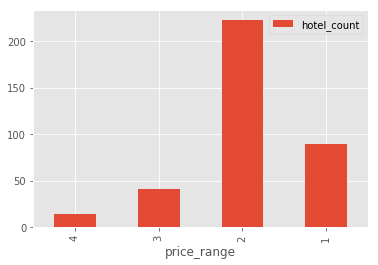

In [11]:
hotel_count.plot.bar(x='price_range')

#### (2) Set attributes to figure out which hotels for each level should be chosen.  
a. The count of words (“romantic”, “dating”, “love”, and “couples”) in review text.  
b. “Stars” and “Review count” above average in business table

#### (3) Sort data by the three attributes together and find out the overall top hotels.

In [12]:
sql = '''
SELECT hotel.*, COUNT(*) AS count FROM
(
    SELECT business.*, attribute.value
    FROM review
    JOIN business ON review.business_id = business.id
    JOIN category ON category.business_id = business.id
    JOIN attribute ON attribute.business_id = business.id
    WHERE category.category = 'Hotels & Travel'
    AND business.city = 'Las Vegas'
    AND business.is_open = 1
    AND (attribute.name = 'RestaurantsPriceRange2' AND attribute.value >= 3)
    AND business.stars >= 3.27
    AND business.review_count >= 157.33
    AND (
        review.text LIKE '%romantic%' 
        or review.text LIKE '%couples%' 
        or review.text LIKE '%love%'
        or review.text LIKE '%dating%'
        )
) AS hotel
JOIN business ON hotel.id = business.id
GROUP BY hotel.id
ORDER BY count DESC, hotel.stars DESC, hotel.review_count DESC
LIMIT 5;
'''
hotel_high = pdSQL.read_sql(sql, dbcon)
hotel_high

id                           name neighborhood  \
0  5LNZ67Yw9RD6nf4_UhXOjw  The Cosmopolitan of Las Vegas    The Strip   
1  SMPbvZLSMMb7KU76YNYMGg           ARIA Resort & Casino    The Strip   
2  Wxxvi3LZbHNIDwJ-ZimtnA         The Venetian Las Vegas    The Strip   
3  WYw3Uf56DT5IwpaLNnCH5Q                    Vdara Hotel    The Strip   
4  na4Th5DrNauOv-c43QQFvA                 Bellagio Hotel    The Strip   

                          address       city state postal_code  latitude  \
0           3708 Las Vegas Blvd S  Las Vegas    NV       89109   36.1097   
1           3730 Las Vegas Blvd S  Las Vegas    NV       89109   36.1076   
2  3355 South Las Vegas Boulevard  Las Vegas    NV       89109   36.1212   
3               2600 W Harmon Ave  Las Vegas    NV       89158   36.1093   
4           3600 S Las Vegas Blvd  Las Vegas    NV       89109   36.1141   

   longitude  stars  review_count  is_open value  count  
0   -115.174    4.0          3621        1     3   1124  
1   -115.177    3.5          3634        1     3   1001  
2   -115.170    4.0          2951        1     3    956  
3   -115.178    4.0          2235        1     3    725  
4   -115.173    3.5          2655        1     3    676

In [13]:
#Save the latitudes and longitudes for mapping
hotel_lats = hotel_high['latitude'][:3].tolist()
hotel_lngs = hotel_high['longitude'][:3].tolist()

In [4]:
sql = '''
SELECT hotel.*, COUNT(*) AS count FROM
(
    SELECT business.*, attribute.value
    FROM review
    JOIN business ON review.business_id = business.id
    JOIN category ON category.business_id = business.id
    JOIN attribute ON attribute.business_id = business.id
    WHERE category.category = 'Hotels & Travel'
    AND business.city = 'Las Vegas'
    AND business.is_open = 1
    AND attribute.name = 'RestaurantsPriceRange2' 
    AND (attribute.value <3 AND attribute.value >=2)
    AND business.stars >= 3.27
    AND business.review_count >= 157.33
    AND (
        review.text LIKE '%romantic%'
        or review.text LIKE '%couples%'
        or review.text LIKE '%love%'
        or review.text LIKE '%dating%'
        )
) AS hotel
JOIN business ON hotel.id = business.id
GROUP BY hotel.id
ORDER BY count DESC, hotel.stars DESC, hotel.review_count DESC
LIMIT 5;
'''
hotel_medium = pdSQL.read_sql(sql, dbcon)
hotel_medium

id                              name     neighborhood  \
0  DfgZlNgKwBvCpA_0alumXw                        The Mirage        The Strip   
1  qjnJFZtsY_nfRzoL3J_UWQ  New York New York Hotel & Casino        The Strip   
2  RhEvP5flF6KoPriMHmVYGg      Red Rock Casino Resort & Spa  South Summerlin   
3  p0iEUamJVp_QpaheE-Nz_g   South Point Hotel, Casino & Spa        Southeast   
4  vnvQ0lD9MDje2DFde9PKQA   Elara by Hilton Grand Vacations        The Strip   

                   address       city state postal_code  latitude  longitude  \
0    3400 Las Vegas Blvd S  Las Vegas    NV       89109   36.1213   -115.175   
1    3790 Las Vegas Blvd S  Las Vegas    NV       89109   36.1011   -115.174   
2  11011 W Charleston Blvd  Las Vegas    NV       89135   36.1564   -115.333   
3    9777 S Las Vegas Blvd  Las Vegas    NV       89183   36.0114   -115.176   
4          80 E Harmon Ave  Las Vegas    NV       89109   36.1084   -115.169   

   stars  review_count  is_open value  count  
0    3.5          1885        1     2    522  
1    3.5          1760        1     2    390  
2    3.5          1338        1     2    342  
3    3.5          1288        1     2    228  
4    3.5           786        1     2    195

In [15]:
for i in range (0,3):
    hotel_lats.append(hotel_medium['latitude'][i].tolist())
for i in range (0,3):
    hotel_lngs.append(hotel_medium['longitude'][i].tolist())

In [16]:
sql = '''
SELECT hotel.*, COUNT(1) AS count 
FROM
    (SELECT business.*, attribute.value
    FROM review
    JOIN business ON review.business_id = business.id
    JOIN category ON category.business_id = business.id
    JOIN attribute ON attribute.business_id = business.id
    WHERE category.category = 'Hotels & Travel'
    AND business.city = 'Las Vegas'
    AND business.is_open = 1
    AND (attribute.name = 'RestaurantsPriceRange2' AND attribute.value = 1)
    AND business.stars >= 3.27
    AND business.review_count >= 157.33
    AND (review.text LIKE '%romantic%'
        or review.text LIKE '%couples%'
        or review.text LIKE '%love%'
        or review.text LIKE '%dating%'
        )
) AS hotel
JOIN business ON hotel.id = business.id
GROUP BY hotel.id
ORDER BY count DESC, hotel.stars DESC, hotel.review_count DESC
LIMIT 5;
'''
hotel_low = pdSQL.read_sql(sql, dbcon)
hotel_low

id                                name neighborhood  \
0  WETHRoXB2IbixndSlOktJA            Lulu's Bread & Breakfast   Centennial   
1  RypJ1Rhq7Y8GFdP5UFbzUg  Centurion Club By American Express    Southeast   
2  nhIWy8eXayUvDzAz3Ef-Og     Best Western Plus Casino Royale    The Strip   
3  68O4uYCd0YToLOLqHTBSZQ    Jeff Civillico: Comedy In Action    The Strip   
4  7zec5DCEukcx8GRFn9LbLQ                         The Volcano    The Strip   

                  address       city state postal_code  latitude  longitude  \
0       6720 Skypointe Dr  Las Vegas    NV       89131   36.2835   -115.270   
1  5757 Wayne Newton Blvd  Las Vegas    NV       89119   36.0818   -115.137   
2   3411 Las Vegas Blvd S  Las Vegas    NV       89109   36.1207   -115.172   
3   3555 Las Vegas Blvd S  Las Vegas    NV       89109   36.1184   -115.172   
4   3400 Las Vegas Blvd S  Las Vegas    NV       89109   36.1213   -115.174   

   stars  review_count  is_open value  count  
0    4.0           411        1     1     91  
1    4.5           353        1     1     50  
2    3.5           280        1     1     41  
3    5.0           161        1     1     40  
4    4.0           172        1     1     19

In [17]:
for i in [2,4]:
    hotel_lats.append(hotel_low['latitude'][i].tolist())
for i in [2,4]:
    hotel_lngs.append(hotel_low['longitude'][i].tolist())

#### <font color = 'blue'> Suggestion: </font>
<font color = 'blue'>
**a. High-end hotels:**  
i. The Cosmopolitan of Las Vegas  
ii. ARIA Resort & Casino  
iii. The Venetian Las Vegas  
**b. Middle-end hotels:**  
                   i. The Mirage   
                  ii. New York New York Hotel & Casino  
                  iii. The Platinum Hotel  
**c. Low-end hotels:**   
       i. Best Western Plus Casino Royale  
                   ii. The Volcano  
</font>

## 2. Restaurants

### 2.1 Romantic

#### (1)	Selecting all restaurants with rating is 4 stars and review count higher than average
#### (2)	Set attributes “Restaurants Reservations” and “Romantic” as ‘true’ to figure out top 3 

In [18]:
#Set some criteria to find our recommendation: restaurant reservation is true, ambience - romantic is true
sql = '''
SELECT lv.*, A3.value AS Price_range
FROM (SELECT business_id
      FROM category
      WHERE category = 'Restaurants'
     ) AS R
JOIN (SELECT *
      FROM business
      WHERE city = 'Las Vegas'
      AND is_open = '1'
      AND stars > 4
      AND review_count > 504
      ) AS lv
ON R.business_id = lv.id
JOIN (SELECT * 
      FROM attribute
      WHERE name = 'RestaurantsReservations') AS A1
ON lv.id = A1.business_id
JOIN(SELECT *
     FROM attribute
     WHERE name = 'Ambience'
     AND value LIKE '{"romantic": true%'
) AS A2
ON A2.business_id = lv.id
JOIN (SELECT * 
      FROM attribute
      WHERE name = 'RestaurantsPriceRange2') AS A3
ON lv.id = A3.business_id
WHERE A1.value = 1
ORDER BY lv.stars DESC, review_count DESC;
'''
Romantic = pdSQL.read_sql(sql, dbcon)
Romantic

id           name neighborhood                address  \
0  0q_BHpxbikVtPRRLRu-U0g        Picasso    The Strip  3600 S Las Vegas Blvd   
1  VG0nWxGsPixYLsyi49gyxQ  Hugo's Cellar     Downtown         202 Fremont St   
2  So132GP_uy3XbGs0KNyzyw  Casa Di Amore    Southeast   2850 E Tropicana Ave   
3  rtlsfmdufArhk-47sWIf2w      Le Cirque    The Strip  3600 S Las Vegas Blvd   

        city state postal_code  latitude  longitude  stars  review_count  \
0  Las Vegas    NV       89109   36.1138   -115.174    4.5           758   
1  Las Vegas    NV       89101   36.1698   -115.144    4.5           724   
2  Las Vegas    NV       89121   36.1003   -115.112    4.5           632   
3  Las Vegas    NV       89109   36.1134   -115.175    4.5           594   

   is_open Price_range  
0        1           4  
1        1           3  
2        1           2  
3        1           4

In [19]:
restaurant_lats = Romantic['latitude'][:3].tolist()
restaurant_lngs = Romantic['longitude'][:3].tolist()

**Top 3**  
	a. Picasso (`$$$$`)  
	b. Hugo’s Cellar  (`$$$`)  
	c. Casa di Amore  (`$$`)

#### (3) Then we take a further step on Picasso to find out more information  
a. Looking at the distribution of the rating of Picasso  
b. Find out the most famous dishes in this restaurant (stars above 3 & use word cloud)


### Picasso

In [20]:
#Picasso
sql = '''
SELECT *
FROM category
WHERE business_id = '0q_BHpxbikVtPRRLRu-U0g';
'''
result = pdSQL.read_sql(sql, dbcon) 
result.head()

business_id     category
0  0q_BHpxbikVtPRRLRu-U0g         Bars
1  0q_BHpxbikVtPRRLRu-U0g  Restaurants
2  0q_BHpxbikVtPRRLRu-U0g      Spanish
3  0q_BHpxbikVtPRRLRu-U0g    Nightlife
4  0q_BHpxbikVtPRRLRu-U0g       French

It's a Spanish and French restaurant.

#### Look at the reviews for Picasso

In [21]:
sql ='''
SELECT stars, text, useful, funny, cool, business_id
FROM review
WHERE business_id = '0q_BHpxbikVtPRRLRu-U0g'
'''
Picasso_review = pdSQL.read_sql(sql, dbcon) 
Picasso_review.head()

stars                                               text  useful  funny  \
0      4  Not that Picasso really gives a shit about wha...       1      2   
1      5  Wow!!! What an incredible experience!!! Great ...       0      0   
2      5  Picasso is truly an experience from the minute...       2      0   
3      4  It's definitely one of the prettiest meals I h...       0      0   
4      5  Very snooty. But I approve nonetheless. \n\nI ...       1      1   

   cool             business_id  
0     1  0q_BHpxbikVtPRRLRu-U0g  
1     0  0q_BHpxbikVtPRRLRu-U0g  
2     1  0q_BHpxbikVtPRRLRu-U0g  
3     0  0q_BHpxbikVtPRRLRu-U0g  
4     0  0q_BHpxbikVtPRRLRu-U0g

In [22]:
len(Picasso_review)

758

#### Look at the distribution of rating for Picasso

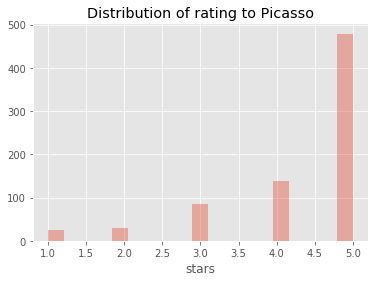

In [23]:
sns.distplot(Picasso_review['stars'], kde = False)
plt.title('Distribution of rating to Picasso')

This is a pretty highed rated restaurant with lots of 5 stars and few 1 or 2 stars.

#### Word cloud

We would like to find out the most famous dishes in this restaurant. To do this, we first choose those reviews with stars of more than 3 and use word cloud to find the most frequently mentioned words.

In [24]:
Picasso_good = Picasso_review.loc[Picasso_review['stars'] > 3]
len(Picasso_good)

617

In [113]:
stopwords = set(STOPWORDS)
stopwords.add('restaurant')
stopwords.add('food')
stopwords.add('one')
stopwords.add('good')
stopwords.add('great')
stopwords.add('best')
stopwords.add('also')
stopwords.add('meal')
stopwords.add('really')
stopwords.add("vegas")
stopwords.add("place")
def red_color(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 50)
lip = np.array(Image.open("lip.jpg"))
def wordcloud_show(review_text, mask, defined_color):
    wc = WordCloud(background_color="white", mask=mask, stopwords=stopwords)
    wc.generate(' '.join(review_text['text'].apply(lambda x: x.lower())))
    plt.figure(figsize=(9, 7), dpi= 80)
    plt.imshow(wc.recolor(color_func=defined_color, random_state=3), interpolation='bilinear')
    plt.axis("off")

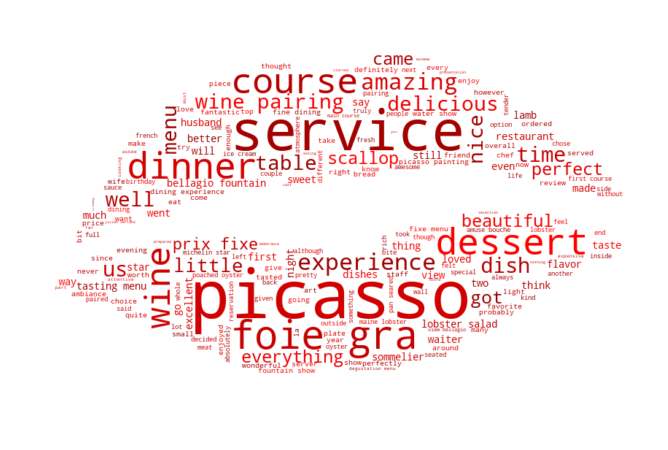

In [26]:
wordcloud_show(Picasso_good, lip, red_color)

**We recommend to try fpie gra with wine pairing and dessert.  
Moreover, select a table that can overlook the Bellagio fountains!**

### Hugo's Cellar

In [27]:
#Hugo's Cellar
sql = '''
SELECT *
FROM category
WHERE business_id = 'VG0nWxGsPixYLsyi49gyxQ';
'''
result = pdSQL.read_sql(sql, dbcon) 
result.head()

business_id                category
0  VG0nWxGsPixYLsyi49gyxQ             Restaurants
1  VG0nWxGsPixYLsyi49gyxQ  American (Traditional)
2  VG0nWxGsPixYLsyi49gyxQ          American (New)
3  VG0nWxGsPixYLsyi49gyxQ                 Seafood
4  VG0nWxGsPixYLsyi49gyxQ             Steakhouses

It's an American restaurant.

#### Look at the reviews for Hugo's Cellar

In [28]:
sql ='''
SELECT stars, text, useful, funny, cool, business_id
FROM review
WHERE business_id = 'VG0nWxGsPixYLsyi49gyxQ'
'''
Hugo_review = pdSQL.read_sql(sql, dbcon) 
Hugo_review.head()

stars                                               text  useful  funny  \
0      5  Perfection with every little touch.  I've live...       0      0   
1      4  Good quality steakhouse.  The salad cart is gr...       0      0   
2      5  I love this joint - been here 3x and every tim...       0      0   
3      5  My go to steakhouse in Las Vegas. Been going h...       0      0   
4      4  This restaurant located below the first floor ...       1      0   

   cool             business_id  
0     0  VG0nWxGsPixYLsyi49gyxQ  
1     0  VG0nWxGsPixYLsyi49gyxQ  
2     0  VG0nWxGsPixYLsyi49gyxQ  
3     0  VG0nWxGsPixYLsyi49gyxQ  
4     1  VG0nWxGsPixYLsyi49gyxQ

In [29]:
Hugo_good = Hugo_review.loc[Hugo_review['stars'] > 3]
len(Hugo_good)

586

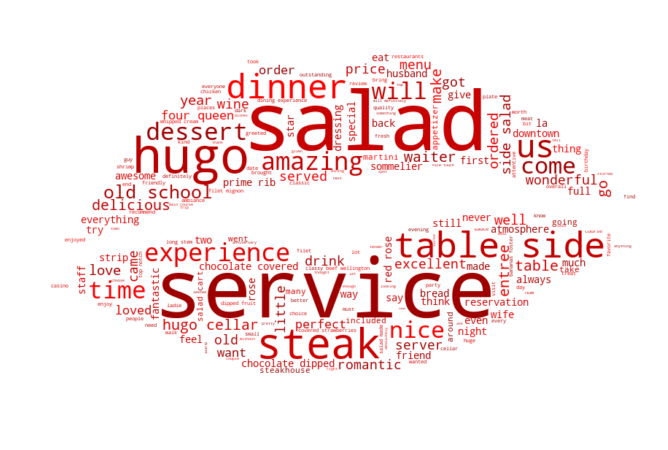

In [30]:
wordcloud_show(Hugo_good, lip, red_color)

**We recommend to try steak and salad.  
Enjoy the service!**

### Casa Di Amore

In [31]:
#Casa Di Amore
sql = '''
SELECT *
FROM category
WHERE business_id = 'So132GP_uy3XbGs0KNyzyw';
'''
result = pdSQL.read_sql(sql, dbcon) 
result.head()

business_id        category
0  So132GP_uy3XbGs0KNyzyw         Seafood
1  So132GP_uy3XbGs0KNyzyw           Pizza
2  So132GP_uy3XbGs0KNyzyw     Restaurants
3  So132GP_uy3XbGs0KNyzyw           Salad
4  So132GP_uy3XbGs0KNyzyw  American (New)

#### Look at the reviews for Casa Di Amore

In [32]:
sql ='''
SELECT stars, text, useful, funny, cool, business_id
FROM review
WHERE business_id = 'So132GP_uy3XbGs0KNyzyw'
'''
Casa_review = pdSQL.read_sql(sql, dbcon) 
Casa_review.head()

stars                                               text  useful  funny  \
0      5  My second favorite Italian place in LV. Great ...       0      0   
1      4  Old style vegas restaurant for sure. Dont let ...       0      0   
2      1  Italian DISASTER!  This place promotes itself ...       0      1   
3      2  The good, the bad or the average first? - I wi...       1      0   
4      2  Went on a Sunday night and was pretty busy. I ...       1      0   

   cool             business_id  
0     0  So132GP_uy3XbGs0KNyzyw  
1     0  So132GP_uy3XbGs0KNyzyw  
2     0  So132GP_uy3XbGs0KNyzyw  
3     0  So132GP_uy3XbGs0KNyzyw  
4     0  So132GP_uy3XbGs0KNyzyw

In [33]:
Casa_good = Casa_review.loc[Casa_review['stars'] > 3]
len(Casa_good)

532

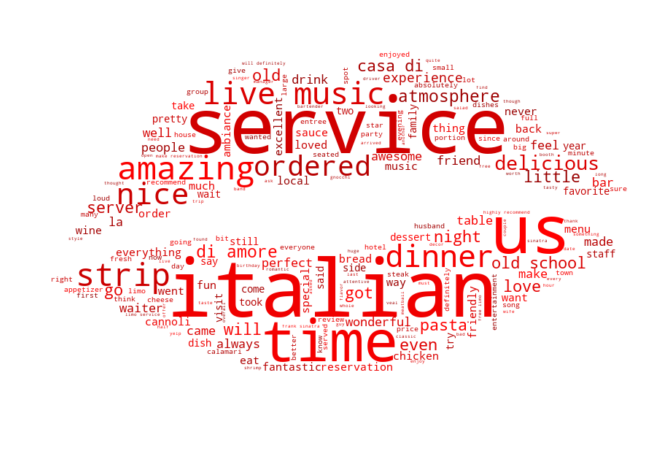

In [34]:
stopwords.add('place')
wordcloud_show(Casa_good, lip, red_color)

**We recommend to enjoy the service and live music there.**

#### <font color = 'blue'> Restaurant suggestions: </font>  
  
<font color = 'blue'>
a. Picasso(`$$$$`)   - [Spanish & French] fpie gra, wine pairing, dessert  
	b. Hugo’s Cellar(`$$$`) - [American]   Steak, salad  
	c. Casa di Amore(`$$`) - [Italian]  enjoy the service and live music
</font>

### 2.2 Buffets

#### (1) Select all restaurants with rating higher than 3 and review counts higher than 100
#### (2) Sort by the descending order of stars to get the best 3 buffets 

In [110]:
# Find the best buffets with higest ratings and enough reviews
sql = '''
SELECT lv.id, lv.name, lv.address, lv.postal_code, lv.latitude, lv.longitude, lv.stars, lv.review_count, A.value AS Price_range
FROM (SELECT business_id
      FROM category
      WHERE category = 'Buffets'
     ) AS buffet
JOIN (SELECT *
      FROM business
      WHERE city = 'Las Vegas'
      AND is_open = '1'
      AND stars > 3
      AND review_count > 100
      AND neighborhood = 'The Strip' 
      ) AS lv
ON buffet.business_id = lv.id
JOIN (SELECT * 
      FROM attribute
      WHERE name = 'RestaurantsPriceRange2') AS A
ON lv.id = A.business_id
ORDER BY lv.stars DESC
LIMIT 3;
'''
Buffet = pdSQL.read_sql(sql, dbcon) 
Buffet

id               name                address  \
0  5z1WIr7E9P2CSzyN5seeSA    Sterling Brunch  3645 Las Vegas Blvd S   
1  RESDUcs7fIiihp38-d6_6g   Bacchanal Buffet  3570 S Las Vegas Blvd   
2  pJpjgXH5lgJtIJos9GqetQ  Buffet of Buffets  3570 S Las Vegas Blvd   

  postal_code  latitude  longitude  stars  review_count Price_range  
0       89109   36.1137   -115.169    4.0           404           4  
1       89109   36.1161   -115.176    4.0          6417           3  
2       89109   36.1179   -115.175    4.0           377           3

In [36]:
for i in range (0,3):
    restaurant_lats.append(Buffet['latitude'][i].tolist())
for i in range (0,3):
    restaurant_lngs.append(Buffet['longitude'][i].tolist())

**Give recommendation to avoid rush hours (We assume that checkin information can represent the customer flows.)**

In [37]:
#Define a function to convert the hour into numeric and sort it
def hour_convert(df):
    df[['hour','minute']] = df['checkin_time'].apply(lambda x:pd.Series([i for i in str(x).split(':')]))
    df = df.drop(['checkin_time', 'minute'], axis=1)
    df['hour'] = df['hour'].astype(int)
    df = df.sort_values('hour')
    return df

**Sterling**

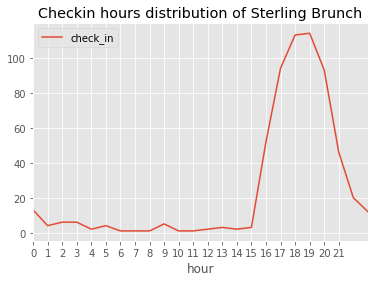

In [38]:
#Draw a graph to show the trends of check-in at Sterling by hours
sql = '''
SELECT checkin_time, sum(count) AS check_in
FROM checkin
WHERE business_id = '5z1WIr7E9P2CSzyN5seeSA'
GROUP BY checkin_time;
'''
Sterling_hour = pdSQL.read_sql(sql, dbcon)

hour_convert(Sterling_hour).plot(x = 'hour', y = 'check_in', kind = 'line')
plt.xticks(np.arange(len(Sterling_hour)))
plt.title('Checkin hours distribution of Sterling Brunch')

Try to avoid the peak hours 17:00 - 20:00.

#### <font color = 'blue'> Buffet suggestions: </font>  
  
<font color = 'blue'>
	a. Sterling Brunch(`$$$$`)  
	b. Bacchanal Buffet(`$$$`)  
	c. Buffet of Buffets(`$$$`)  
</font>

## 2.3 Brunches

#### (1) Select all restaurants with rating higher than 3 and review counts higher than 100
#### (2) Sort by the descending order of stars and review counts to get the best and most famous 3


In [39]:
sql ='''
SELECT lv.*, A.value AS Price_range
FROM (SELECT business_id
      FROM category
      WHERE category LIKE '%Brunch'
     ) AS brunch
JOIN (SELECT *
      FROM business
      WHERE city = 'Las Vegas'
      AND is_open = '1'
      AND stars > 3.5
      AND review_count > 100
      AND neighborhood = 'The Strip'
      ) AS lv
ON brunch.business_id = lv.id
JOIN (SELECT * 
      FROM attribute
      WHERE name = 'RestaurantsPriceRange2') AS A
ON lv.id = A.business_id
ORDER BY lv.stars DESC, lv.review_count DESC
LIMIT 5
'''
Brunch = pdSQL.read_sql(sql, dbcon) 
Brunch

id                          name neighborhood  \
0  0d0i0FaJq1GIeW1rS2D-5w                        Bruxie    The Strip   
1  4JNXUYY8wbaaDmk3BPzlWw                  Mon Ami Gabi    The Strip   
2  RESDUcs7fIiihp38-d6_6g              Bacchanal Buffet    The Strip   
3  f4x1YBxkLrZg652xt2KR5g            Hash House A Go Go    The Strip   
4  rcaPajgKOJC2vo_l3xa42A  Bouchon at the Venezia Tower    The Strip   

                                             address       city state  \
0  3782 S Las Vegas Blvd, South Tenant Block, Bld...  Las Vegas    NV   
1                              3655 Las Vegas Blvd S  Las Vegas    NV   
2                              3570 S Las Vegas Blvd  Las Vegas    NV   
3                                3535 Las Vegas Blvd  Las Vegas    NV   
4   3355 Las Vegas Blvd S, Venezia Tower, 10th floor  Las Vegas    NV   

  postal_code  latitude  longitude  stars  review_count  is_open Price_range  
0       89109   36.1033   -115.174    4.5           720        1           2  
1       89109   36.1128   -115.173    4.0          6979        1           2  
2       89109   36.1161   -115.176    4.0          6417        1           3  
3       89109   36.1182   -115.172    4.0          4371        1           2  
4       89109   36.1227   -115.170    4.0          3439        1           3

In [40]:
for i in range (0,3):
    restaurant_lats.append(Brunch['latitude'][i].tolist())
for i in range (0,3):
    restaurant_lngs.append(Brunch['longitude'][i].tolist())

#### (3) Then we take a further step on these 3 brunches to find out more information (the same method as in the Romantic Restaurant)  

**Look at the reviews for Bruxie**

In [41]:
sql ='''
SELECT stars, text, useful, funny, cool, business_id
FROM review
WHERE business_id = '0d0i0FaJq1GIeW1rS2D-5w'
'''
Bruxie_review = pdSQL.read_sql(sql, dbcon) 
Bruxie_review.head()

stars                                               text  useful  funny  \
0      5  Thr line was medium-lonh, but moved quickly. V...       0      0   
1      5  Delicious food, super nice and friendly staff,...       1      0   
2      5  Chicken and waffles, What a pair with custard ...       0      0   
3      4  The food great!! Nice atmosphere and great bee...       0      0   
4      5  I returned for a repeat and was pleased. I als...       0      0   

   cool             business_id  
0     0  0d0i0FaJq1GIeW1rS2D-5w  
1     0  0d0i0FaJq1GIeW1rS2D-5w  
2     0  0d0i0FaJq1GIeW1rS2D-5w  
3     0  0d0i0FaJq1GIeW1rS2D-5w  
4     0  0d0i0FaJq1GIeW1rS2D-5w

In [42]:
Bruxie_good = Bruxie_review.loc[Bruxie_review['stars'] >= 3]
len(Bruxie_good)

674

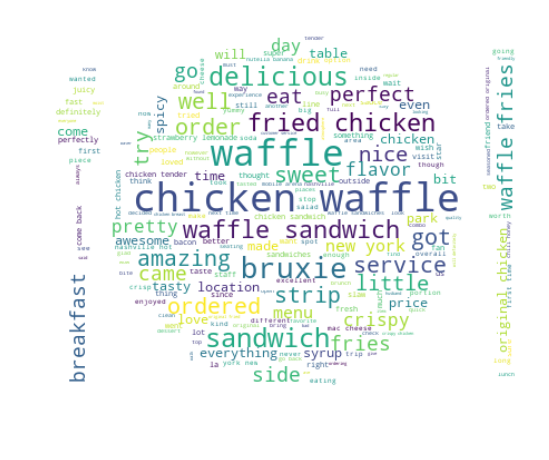

In [114]:
food = np.array(Image.open("food.jpg"))
wordcloud_show(Bruxie_good, food, None)

**Chicken waffle is the most frequently mentioned dish in Bruxie's good reviews. We recommend our clients to try the chicken waffle in this restaurant.**

**Look at the reviews for Mon Ami Gabi**

In [44]:
sql ='''
SELECT stars, text, useful, funny, cool, business_id
FROM review
WHERE business_id = '4JNXUYY8wbaaDmk3BPzlWw'
'''
MAG_review = pdSQL.read_sql(sql, dbcon) 

In [45]:
MAG_good = MAG_review.loc[MAG_review['stars'] > 3]
len(MAG_good)

5544

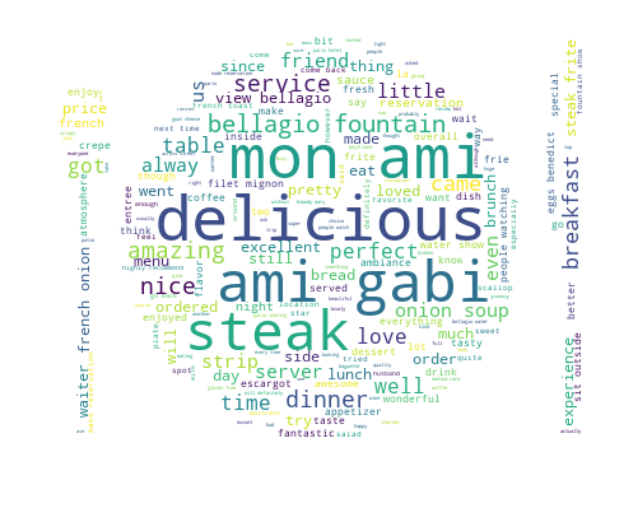

In [46]:
wordcloud_show(MAG_good, food, None)

**We recommend to try steak while enjoying the view of Bellagio fountain.**

**Look at the reviews for Hash House A Go Go**

In [47]:
sql ='''
SELECT stars, text, useful, funny, cool, business_id
FROM review
WHERE business_id = 'f4x1YBxkLrZg652xt2KR5g'
'''
HashHouse_review = pdSQL.read_sql(sql, dbcon) 

In [48]:
HashHouse_good = HashHouse_review.loc[HashHouse_review['stars'] > 3]
len(HashHouse_good)

3096

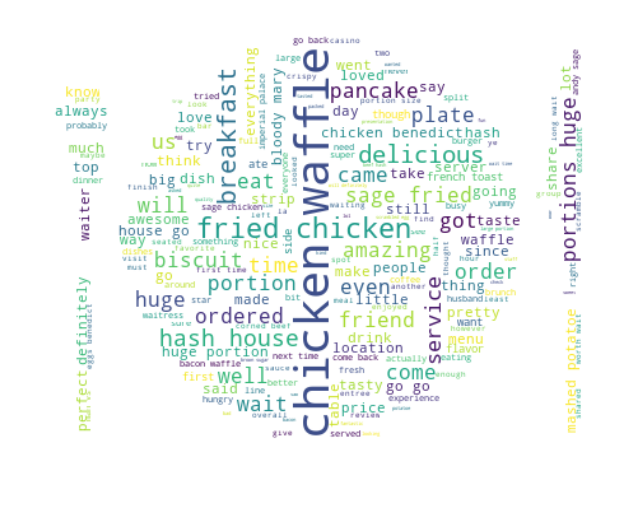

In [49]:
wordcloud_show(HashHouse_good, food, None)

**We recommend to try chicken waffle and fried chicken.**

#### <font color = 'blue'> Brunch suggestions: </font>  
  
<font color = 'blue'>
	a. Bruxie(`$$`) Waffle sandwich   
	b. Mon Ami Gabi(`$$`)  Steak  
	c. Hash House A Go Go(`$$`)  Chicken waffle
</font>

## 3.	Activities and Entertainment 

## 3.1	Shopping Centers

In order to select out shopping centers, we divide all open shopping centers in Las Vegas to 3 levels by number of "$". And in each level, we filter those shopping centers by review text that contain related words and order them by stars and review count.

#### (1) Divide all the shopping centers into 3 levels by number of `$` 
a. High-end level: more than 3 `$`  
b. Middle-end level: 2 to 3 `$`  
c. Low-end level: less than 2 `4` 

#### (2) Set attributes to figure out which shopping center for each level should be chosen
a. The count of words (“discount”, “convenient”, “brand”) in review text.  
b. The rating of shopping centers which is “stars” in business table.  
c. The review count of each shopping centers.


#### (3) Sort data by the three attributes together and find out the top shopping centers

In [50]:
# Low-end shopping centers
sql = '''
SELECT shopping.*, COUNT(*) AS count 
FROM
(
SELECT business.*, attribute.value
FROM review
JOIN business ON review.business_id = business.id
JOIN category ON category.business_id = business.id
JOIN attribute ON attribute.business_id = business.id
WHERE category.category = 'Shopping Centers'
AND business.city = 'Las Vegas'
AND business.is_open = 1
AND attribute.name = 'RestaurantsPriceRange2' 
AND (attribute.value <2 AND attribute.value >=1)
AND (
(review.text LIKE '%discount%' )
    or (review.text LIKE '%brand%' )
    or (review.text LIKE '%convien%' )
    )
) AS shopping
JOIN business ON shopping.id = business.id
GROUP BY shopping.id
ORDER BY count DESC, shopping.stars DESC, shopping.review_count DESC
LIMIT 3;
'''
Low_end = pdSQL.read_sql(sql, dbcon)
Low_end

id                       name neighborhood  \
0  cL2mykvopw-kodSyc-z5jA  Fantastic Indoor Swapmeet     Westside   
1  67hxU1gcm2QCJDwi2GJFxQ          Bonanza Gift Shop    The Strip   
2  NoN4cJyR-OGdNCITPq_Mcg                 Party Stop    Southeast   

                        address       city state postal_code  latitude  \
0           1717 S Decatur Blvd  Las Vegas    NV       89102   36.1508   
1         2440 Las Vegas Blvd S  Las Vegas    NV       89104   36.1442   
2  9890 S Maryland Pkwy, Ste 11  Las Vegas    NV       89183   36.0102   

   longitude  stars  review_count  is_open value  count  
0   -115.206    3.5           146        1     1     13  
1   -115.157    3.0           158        1     1      3  
2   -115.135    5.0            42        1     1      2

In [51]:
shopping_lats = []
shopping_lngs = []
shopping_lats.append(Low_end['latitude'][0].tolist())
shopping_lngs.append(Low_end['longitude'][0].tolist())

Recommended shopping center: Fantastic Indoor Swapment

In [52]:
# Medium-end shopping centers
sql = '''
SELECT shopping.*, COUNT(*) AS count 
FROM
(
SELECT business.*, attribute.value
FROM review
JOIN business ON review.business_id = business.id
JOIN category ON category.business_id = business.id
JOIN attribute ON attribute.business_id = business.id
WHERE category.category = 'Shopping Centers'
AND business.city = 'Las Vegas'
AND business.is_open = 1
AND attribute.name = 'RestaurantsPriceRange2' 
AND (attribute.value <3 AND attribute.value >=2)
AND (
(review.text LIKE '%discount%' )
    or (review.text LIKE '%brand%' )
    or (review.text LIKE '%convien%' )
    )
) AS shopping
JOIN business ON shopping.id = business.id
GROUP BY shopping.id
ORDER BY count DESC, shopping.stars DESC, shopping.review_count DESC
LIMIT 5;
'''
Medium_end = pdSQL.read_sql(sql, dbcon)
Medium_end

id                             name neighborhood  \
0  GHS1rVjO-RMcRB6WJLpCDQ  Las Vegas North Premium Outlets     Downtown   
1  9edPSkfXKsJmkZYIaOmA7Q  Las Vegas South Premium Outlets    Southeast   
2  IB8zLlGraOg9LU7qQVLPyg                     Fashion Show    The Strip   
3  EhIMjTklf4QPvRvMIhoQiA               Miracle Mile Shops    The Strip   
4  gy-HBIeJGlQHs4RRYDLuHw            Town Square Las Vegas    Southeast   

                          address       city state postal_code  latitude  \
0        875 S Grand Central Pkwy  Las Vegas    NV       89106   36.1637   
1           7400 Las Vegas Blvd S  Las Vegas    NV       89123   36.0539   
2  3200 Las Vegas Blvd S, Ste 600  Las Vegas    NV       89109   36.1268   
3           3667 Las Vegas Blvd S  Las Vegas    NV       89109   36.1099   
4           6605 Las Vegas Blvd S  Las Vegas    NV       89119   36.0672   

   longitude  stars  review_count  is_open value  count  
0   -115.158    4.0           851        1     2    169  
1   -115.169    3.5           364        1     2     69  
2   -115.175    4.0           642        1     2     44  
3   -115.170    3.5           431        1     2     37  
4   -115.176    4.0           483        1     2     18

In [53]:
for i in [0,2,4]:
    shopping_lats.append(Medium_end['latitude'][i].tolist())
for i in [0,2,4]:
    shopping_lngs.append(Medium_end['longitude'][i].tolist())

Recommended shopping center: 1. Las Vegas North Premium Outlets 2. Fashion SHow 3. Town Square Las Vegas

In [54]:
# High-end shopping centers
sql = '''
SELECT shopping.*, COUNT(*) AS count 
FROM
(
SELECT business.*, attribute.value
FROM review
JOIN business ON review.business_id = business.id
JOIN category ON category.business_id = business.id
JOIN attribute ON attribute.business_id = business.id
WHERE category.category = 'Shopping Centers'
AND business.city = 'Las Vegas'
AND business.is_open = 1
AND attribute.name = 'RestaurantsPriceRange2' 
AND attribute.value >=3
AND (
(review.text LIKE '%discount%' )
    or (review.text LIKE '%brand%' )
    or (review.text LIKE '%convien%' )
    )
) AS shopping
JOIN business ON shopping.id = business.id
GROUP BY shopping.id
ORDER BY count DESC, shopping.stars DESC, shopping.review_count DESC
LIMIT 3;
'''
High_end = pdSQL.read_sql(sql, dbcon)
High_end

id                        name neighborhood  \
0  DxgSVufr_6y_Rc63CC17Zg  The Forum Shops at Caesars    The Strip   
1  dcqHjnmKPDdOseYEo6SdAw       The Shops at Crystals    The Strip   
2  UXgaUOaXsplzZeALU5ytsA        R+D Hipster Emporium     Westside   

                      address       city state postal_code  latitude  \
0       3500 Las Vegas Blvd S  Las Vegas    NV       89109   36.1190   
1       3720 S Las Vegas Blvd  Las Vegas    NV       89158   36.1079   
2  740 S Rampart Blvd, Ste 11  Las Vegas    NV       89145   36.1635   

   longitude  stars  review_count  is_open value  count  
0   -115.176    4.0           587        1     3     51  
1   -115.174    3.5           310        1     4     24  
2   -115.289    4.0            24        1     3      8

In [55]:
shopping_lats.append(High_end['latitude'][0].tolist())
shopping_lngs.append(High_end['longitude'][0].tolist())

Recommended shopping center: The Forum Shops at Caesars

#### <font color = 'blue'> Shopping center suggestions:</font>
<font color = 'blue'>a. High-end shopping centers: The Forum Shops at Caesars  
b. Middle-end shopping centers:  
i. Las Vegas North Premium Outlets   
ii. Fashion SHow Town  
iii. Square Las Vegas  
c. Low-end shopping centers: Fantastic Indoor Swapment </font>

### 3.2 Attractions

In order to select out attractions, we filter those attraction which are under Landmarks & Historical Buildings by review text that contain related words and order them by stars and review count.

#### (1) Set attributes to figure out which attractions should be chosen
a. The count of words (“interest”, “dating”, “couples”, “recommend”, “great”, “awesome”) in review text.  
b. The rating of attractions which is “stars” in business table.  
c. The review count of each attractions.

#### (2) Sort data by the three attributes together and find out the overall top 4 attractions

In [56]:
sql = '''
SELECT attraction.*, COUNT(*) AS count 
FROM
(
SELECT business.*
FROM review
JOIN business ON review.business_id = business.id
JOIN category ON category.business_id = business.id
JOIN attribute ON attribute.business_id = business.id
WHERE category.category = 'Landmarks & Historical Buildings'
AND business.city = 'Las Vegas'
AND business.is_open = 1
AND ( 
(review.text LIKE '%interest%')
OR (review.text LIKE '%great%')
OR (review.text LIKE '%awesome%')
OR (review.text LIKE '%recommend%')
OR (review.text LIKE '%dating%')
OR (review.text LIKE '%couple%')
)
) AS attraction
JOIN business ON attraction.id = business.id
GROUP BY attraction.id
ORDER BY count DESC, attraction.stars DESC, attraction.review_count DESC;
'''
attraction = pdSQL.read_sql(sql, dbcon)
attraction

id                               name neighborhood  \
0  NCFwm2-TDb-oBQ2medmYDg              Fountains of Bellagio    The Strip   
1  zNOfHgMWZtG1vVA3Ca9fCQ                 Paris Eiffel Tower    The Strip   
2  9Bu4mbMrtSq6lrAtSjJq2w                Bullets and Burgers                
3  f-Tr1CGq7u0JIej6GH2Y1w  Wayne Newton's Casa de Shenandoah    Southeast   
4  2x7wI6CrxO2N_DbwsBtr5A                  Hoover Dam Bridge                
5  ZR4ExGUzWOlZuYqNXVipzw       Crazy Girls Bronze Sculpture    The Strip   

                 address       city state postal_code  latitude  longitude  \
0  3600 S Las Vegas Blvd  Las Vegas    NV       89109   36.1123   -115.177   
1  3655 Las Vegas Blvd S  Las Vegas    NV       89162   36.1129   -115.171   
2    3113 W Tompkins Ave  Las Vegas    NV       89103   36.1040   -115.183   
3       3310 E Sunset Rd  Las Vegas    NV       89120   36.0720   -115.103   
4        Great Basin Hwy  Las Vegas    NV       89005   36.0124   -114.742   
5  2901 Las Vegas Blvd S  Las Vegas    NV       89109   36.1354   -115.160   

   stars  review_count  is_open  count  
0    4.5          1083        1    338  
1    4.0           363        1    171  
2    5.0             9        1     35  
3    4.5            55        1     34  
4    4.5            52        1     22  
5    4.0             9        1     14

In [57]:
attraction_lats = attraction['latitude'][:5].tolist()
attraction_lngs = attraction['longitude'][:5].tolist()

#### <font color = 'blue'> Attraction suggestions:</font>
<font color = 'blue'>1. Fountains of Bellagio  
    2. Paris Eiffel Tower  
    3. Wayne Newton's Casa de Shenandoah  
    4. Hoover Dam Bridge </font>

### 3.3 Shows

#### (1) Set attributes to figure out which shows should be chosen
a. The count of words (“romantic”, “love”, “couples”, “dating”) in review text.  
b. The rating of show which is “stars” in business table.  
c. The review count of each show.

####  (2) Sort data by the three attributes together and find out the overall top 5 shows

In [58]:
sql = '''
SELECT perform.*, COUNT(*) AS count FROM
(
SELECT business.* FROM review
JOIN business ON review.business_id = business.id
JOIN category ON category.business_id = business.id
WHERE category.category = 'Performing Arts'
AND business.city = 'Las Vegas'
AND business.is_open = 1
AND (
    (review.text LIKE '%romantic%' )
    or (review.text LIKE '%couples%' )
    or (review.text LIKE '%love%' )
    or (review.text LIKE '%dating%')
    )
) AS perform
JOIN business 
ON perform.id = business.id
GROUP BY perform.id
ORDER BY count DESC, perform.stars DESC, perform.review_count DESC
LIMIT 5;
'''
show = pdSQL.read_sql(sql, dbcon)
show

id                                 name neighborhood  \
0  mz9ltimeAIy2c2qf5ctljw  Cirque du Soleil - The Beatles LOVE    The Strip   
1  DXlDzOcpdUE_F21tok0fgw               KA by Cirque Du Soleil    The Strip   
2  oVrvzUJczq0e2JzVxSTyag          Cirque du Soleil - Zumanity    The Strip   
3  BH9z7IJ4zydAqgwsbqoVZQ                 Cirque du Soleil - O    The Strip   
4  ty5KQYqYRxwXDG_e4pz-4w                             Absinthe    The Strip   

                                             address       city state  \
0     The Mirage Hotel Casino, 3400 Las Vegas Blvd S  Las Vegas    NV   
1  Mgm Grand Hotel And Casino, 3799 Las Vegas Bou...  Las Vegas    NV   
2  New York - New York Las Vegas Hotel Casino, 37...  Las Vegas    NV   
3          Bellagio Las Vegas, 3600 S Las Vegas Blvd  Las Vegas    NV   
4                                        Flamingo Rd  Las Vegas    NV   

  postal_code  latitude  longitude  stars  review_count  is_open  count  
0       89109   36.1213   -115.175    4.5          1766        1   1000  
1       89109   36.1033   -115.170    4.0          1686        1    487  
2       89109   36.1029   -115.175    4.0          1273        1    435  
3       89109   36.1141   -115.177    4.5          1373        1    365  
4       89109   36.1140   -115.174    4.5          1452        1    353

In [59]:
show_lats = show['latitude'][:5].tolist()
show_lngs = show['longitude'][:5].tolist()

#### <font color = 'blue'> Shows suggestions:</font>
<font color = 'blue'>1. Cirque du Soleil - The Beatles LOVE  
2. KA by Cirque Du Soleil  
3. Cirque du Soleil - O	
4. Absinthe  
5. Le Reve - The Dream </font>

### 3.4 Bars & Gay Bars

### 3.4.1 Bars

#### (1) Set attributes to figure out which Bars should be chosen
a. Set stars = 5 for Bars  	
b. Set review count above 75% (get 11 bars), then set review count above 60 (get 3 Bars)  

In [60]:
sql = '''
SELECT business.* FROM business   
JOIN category ON business.id = category.business_id
WHERE category.category = 'Bars'
AND business.city = "Las Vegas"
AND business.is_open = 1
'''
bar = pdSQL.read_sql(sql, dbcon)
bar.head()

id          name neighborhood                address  \
0  -3zffZUHoY8bQjGfPSoBKQ  Michael Mina    The Strip  3600 S Las Vegas Blvd   
1  -a857YYdjzgOdOjFFRsRXQ     Beer Park    The Strip  3655 S Las Vegas Blvd   
2  -B1PzLYsOSL9rda--Wr7tQ     Flare Bar    Southwest   3333 Blue Diamond Rd   
3  -CQokjildrY7UZezXCdEBw    Toddy Shop     Westside     238 S Rainbow Blvd   
4  -G9DFmuokdYk_H35ezRkAw   Dolphin Bar    The Strip  3400 Las Vegas Blvd S   

        city state postal_code  latitude  longitude  stars  review_count  \
0  Las Vegas    NV       89109   36.1120   -115.177    4.0           574   
1  Las Vegas    NV       89109   36.1120   -115.172    3.5           260   
2  Las Vegas    NV       89139   36.0419   -115.185    4.0             4   
3  Las Vegas    NV       89145   36.1714   -115.245    5.0            40   
4  Las Vegas    NV       89109   36.1213   -115.172    4.0             7   

   is_open  
0        1  
1        1  
2        1  
3        1  
4        1

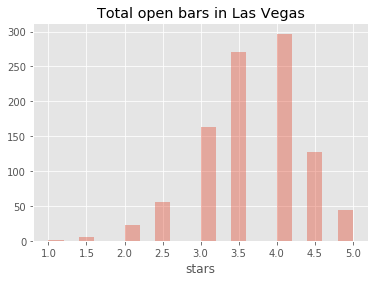

In [61]:
#look at the open Bars' stars distribution in Las Vegas
ax = plt.axes()
sns.distplot(bar['stars'], kde = False)
ax.set_title('Total open bars in Las Vegas')

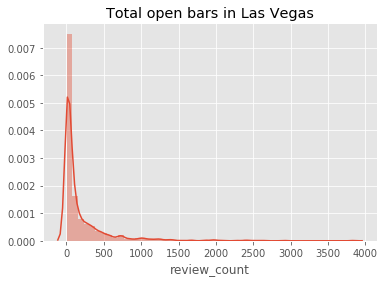

In [62]:
#look at the open Bars' review_count distribution in Las Vegas
ax = plt.axes()
sns.distplot(bar['review_count'], ax=ax)
ax.set_title('Total open bars in Las Vegas')

#### (2) Sort data by the two attributes together and find out the overall top 3 Bars

In [63]:
#Open Bars in Las Vegas that have the highest stars, which is 5 
bar_stars5 = bar.loc[bar['stars'] == 5]
len(bar_stars5)

44

In [64]:
#Check the statistics related to open Bars with 5 stars in Las Vegas 
bar_stars5['review_count'].describe()

count     44.000000
mean      22.772727
std       34.141200
min        3.000000
25%        4.000000
50%        8.000000
75%       28.500000
max      196.000000
Name: review_count, dtype: float64

In [65]:
#Choice1: Show 5 stars open Bars that have the above the 75% number of reveiw_count
bar_stars5_reviewcount1 = bar_stars5.loc[bar_stars5['review_count'] > 28.500000]
#total open 5 stars bars in Las Vegas with review count more than 75% 
len(bar_stars5_reviewcount1)

11

In [66]:
#Choice2: Only show top 3 review counts' Bars that are openned with 5 stars.
bar_stars5_reviewcount2 = bar_stars5.loc[bar_stars5['review_count'] > 60]
bar_stars5_reviewcount2.head()

id                                name neighborhood  \
68   3pSUr_cdrphurO6m1HMP9A                       J Karaoke Bar    Chinatown   
181  A7Hb0SEYZH-n70SS4DKJJA  Surreal Nightlife & Bottle Service    The Strip   
213  ay6V-SfANiKOZvma7iZS0Q            En Fuego Cigars & Lounge    The Strip   

                     address       city state postal_code  latitude  \
68   3899 Spring Mountain Rd  Las Vegas    NV       89102   36.1264   
181                           Las Vegas    NV       89109   36.1286   
213         328 W Sahara Ave  Las Vegas    NV       89102   36.1442   

     longitude  stars  review_count  is_open  
68    -115.192    5.0           196        1  
181   -115.171    5.0            64        1  
213   -115.162    5.0            94        1

In [67]:
bar_lats = bar_stars5_reviewcount2['latitude'][:3].tolist()
bar_lngs = bar_stars5_reviewcount2['longitude'][:3].tolist()

Suggestion For Couples:
We found that J Karoke Bar has the highest review counts and also has the stars of 5, So we strongly recommand it to the couple to visit. If they don't like this one, they can either go to the En Fuego Cigars & Lounge Bar, or Surreal Nightlife & Bottle Service Bar.

### 3.4.2 Gay Bars

#### (1) Set attributes to figure out which Gay Bars should be chosen  
a. Set stars above mean for Gay Bars (because not so many Gay Bars)  
b. Set review count above mean for Gay Bars (get 3 Gay Bars) 

In [68]:
sql = '''
SELECT business.* FROM business   
JOIN category ON business.id = category.business_id
WHERE category.category = 'Gay Bars'
AND business.city = "Las Vegas"
AND business.is_open = 1
'''
gaybar = pdSQL.read_sql(sql, dbcon)
gaybar.head()

id                  name neighborhood  \
0  03hmuxN-jpGWjdtBnhV2AQ  Flex Cocktail Lounge     Westside   
1  1PVFYjySeMsHUYnshzpAGw     Piranha Nightclub     Eastside   
2  2g8LJSC_Ia9fZxdQRSVLig              Bastille     Downtown   
3  5eqm4pyz-egd255X7PB8Xg       Las Vegas Eagle     Eastside   
4  67OIG-1s4IAXb-YXNk6ZJg   Charlie's Las Vegas                

                        address       city state postal_code  latitude  \
0        4371 W Charleston Blvd  Las Vegas    NV       89102   36.1588   
1            4633 S Paradise Rd  Las Vegas    NV       89169   36.1055   
2                 1402 S 3rd St  Las Vegas    NV       89104   36.1545   
3  3430 E Tropicana Ave, Ste 47  Las Vegas    NV       89121   36.1015   
4        5012 Arville St, Ste 4  Las Vegas    NV       89118   36.0986   

   longitude  stars  review_count  is_open  
0   -115.200    4.0            28        1  
1   -115.152    3.0           230        1  
2   -115.151    4.0            38        1  
3   -115.100    2.5            23        1  
4   -115.199    3.0            53        1

In [69]:
len(gaybar)

16

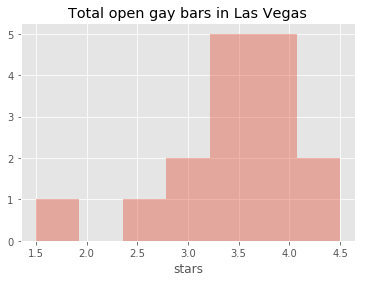

In [70]:
#look at the open Gay Bars' stars distribution 
ax = plt.axes()
sns.distplot(gaybar['stars'], kde = False)
ax.set_title('Total open gay bars in Las Vegas')

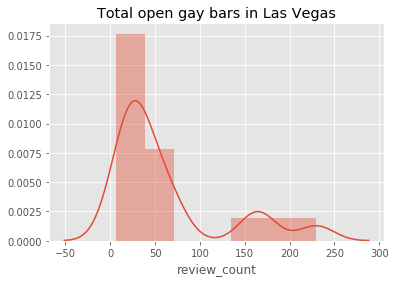

In [71]:
#look at the open Gay Bars' review_count distribution
ax = plt.axes()
sns.distplot(gaybar['review_count'], ax=ax)
ax.set_title('Total open gay bars in Las Vegas')

#### (2) Sort data by the two attributes together and find out the overall top 3 Gay Bars

In [72]:
#Becasue there are not so many Gay Bars. 
#So we decided to show Gay Bars'stars that are above the mean stars of 3.53125
gaybar_good = gaybar.loc[gaybar['stars']>gaybar['stars'].mean()]
#total open Gay Bars in Las Vegas with a stars above the mean 
len(gaybar_good)

7

In [73]:
#Choice: Show open Gay Bars with above mean stars & above mean reveiw_count
gaybar_good_reviewcount = gaybar_good.loc[gaybar_good['review_count'] > gaybar_good['review_count'].mean()]
gaybar_good_reviewcount.head()

id                      name neighborhood  \
8   i_K9elBRuVJsKEl8nsu5Yg             Fun Hog Ranch     Eastside   
9   J5ylw6DXGmQ6hM06Ne3XHw  The Phoenix Bar & Lounge     Westside   
12  QkDhw-fQi_IijlqSnV3eIg                The Garage   University   

                      address       city state postal_code  latitude  \
8             495 E Twain Ave  Las Vegas    NV       89169   36.1209   
9           4213 W Sahara Ave  Las Vegas    NV       89102   36.1440   
12  1487 E Flamingo Rd, Ste C  Las Vegas    NV       89119   36.1138   

    longitude  stars  review_count  is_open  
8    -115.152    4.0            69        1  
9    -115.198    4.0            68        1  
12   -115.134    4.5           169        1

In [74]:
gaybar_lats = gaybar_good_reviewcount['latitude'][:3].tolist()
gaybar_lngs = gaybar_good_reviewcount['longitude'][:3].tolist()

Suggestion For Gay Couples:    
We found that The Garage Bar has the highest review counts and highest stars of 4.5, So we strongly recommand it to the gay couples to visit. If they don't like this one, they can either go to  Fun Hog Ranch, or The Phoenix Bar & Lounge.

In the following analysis, we will only focus on top 3 open Bars and top 3 open Gay Bars in Las Vegas.

#### <font color = 'blue'> Bars suggestions:</font>
<font color = 'blue'>
**a. Top 3 Bars**  
	i. J Karaoke Bar  
	ii En Fuego Cigars & Lounge  
	iii Surreal Nightlife & Bottle Service   
**b. Top 3 Gay Bars**  
	i. The Garage  
	ii. Fun Hog Ranch  
	iii. The Phoenix Bar & Lounge   
 </font>

#### (3) Word Cloud of each Bars and Gays Bars so that our guest can choose the one they liked.

In [75]:
stopwords.add("place")
stopwords.add("us")
stopwords.add("room")

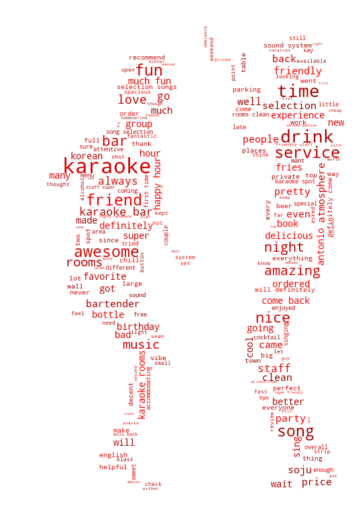

In [76]:
# First bar: J Karoke Bar
sql = '''
SELECT *
FROM review
WHERE business_id = '3pSUr_cdrphurO6m1HMP9A'
'''
JK_review = pdSQL.read_sql(sql, dbcon)
couple1 = np.array(Image.open("couple1.jpg"))
wordcloud_show(JK_review,couple1, red_color)

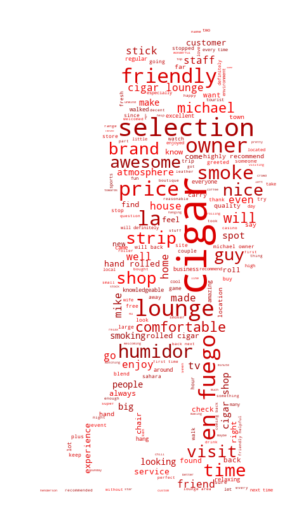

In [77]:
# Second Bar: En Fuego Cigars & Lounge
sql = '''
SELECT *
FROM review
WHERE business_id = 'ay6V-SfANiKOZvma7iZS0Q'
'''
En_review = pdSQL.read_sql(sql, dbcon)
couple2 = np.array(Image.open("couple2.png"))
wordcloud_show(En_review,couple2, red_color)

In [78]:
stopwords.add("brian")
stopwords.add("thank")

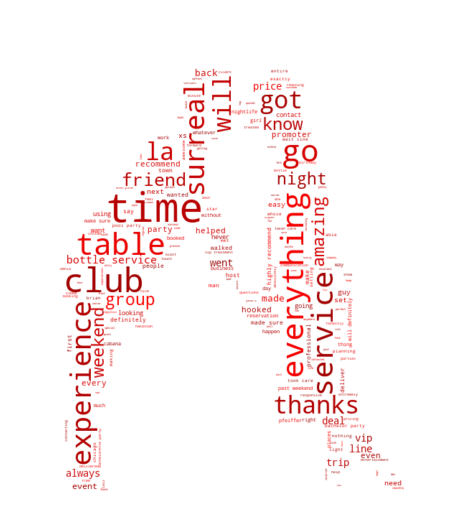

In [79]:
# Third Bar: Surreal Nightlife & Bottle Service
sql = '''
SELECT *
FROM review
WHERE business_id = 'A7Hb0SEYZH-n70SS4DKJJA'
'''
Surreal_review = pdSQL.read_sql(sql, dbcon)
couple3 = np.array(Image.open("couple3.png"))
wordcloud_show(Surreal_review, couple3, red_color)

In [80]:
def rainbow_color(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(%d, 100%%, 50%%)" % random.randint(0, 360)

In [81]:
stopwords.add("bar")
stopwords.add("drink")

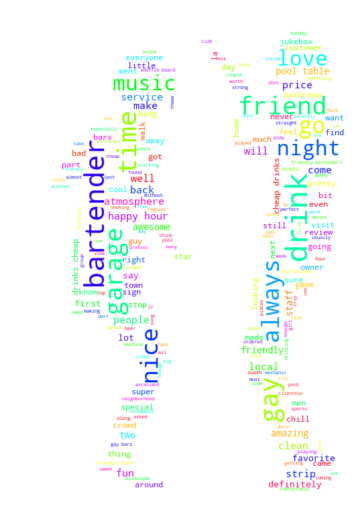

In [82]:
#First Gay Bar: The Garage
sql = '''
SELECT *
FROM review
WHERE business_id = 'QkDhw-fQi_IijlqSnV3eIg'
'''
Garage_review = pdSQL.read_sql(sql, dbcon)
wordcloud_show(Garage_review, couple1, rainbow_color)

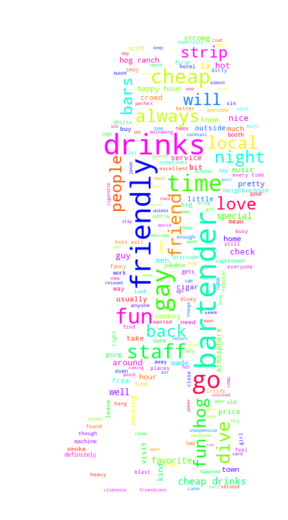

In [83]:
# Second Gay Bar: Fun Hog Ranch
sql = '''
SELECT *
FROM review
WHERE business_id = 'i_K9elBRuVJsKEl8nsu5Yg'
'''
Fun_review = pdSQL.read_sql(sql, dbcon)
wordcloud_show(Fun_review, couple2, rainbow_color)

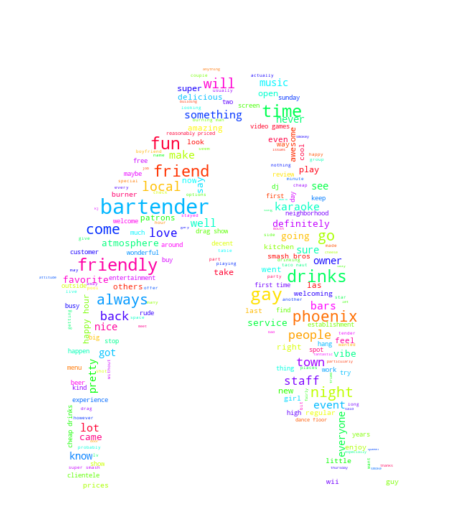

In [84]:
# Third Gay Bar: The Phoenix Bar & Lounge
sql = '''
SELECT *
FROM review
WHERE business_id = 'J5ylw6DXGmQ6hM06Ne3XHw'
'''
Phoenix_review = pdSQL.read_sql(sql, dbcon)
wordcloud_show(Phoenix_review, couple3, rainbow_color)

#### <font color = 'blue'> Suggestion: You Can Make Your Own Chice </font>
<font color = 'blue'>Our guests can choose the one they like based on the wordcloud pictures</font>

## Part 3: Results

### 3.1 Our Brohure

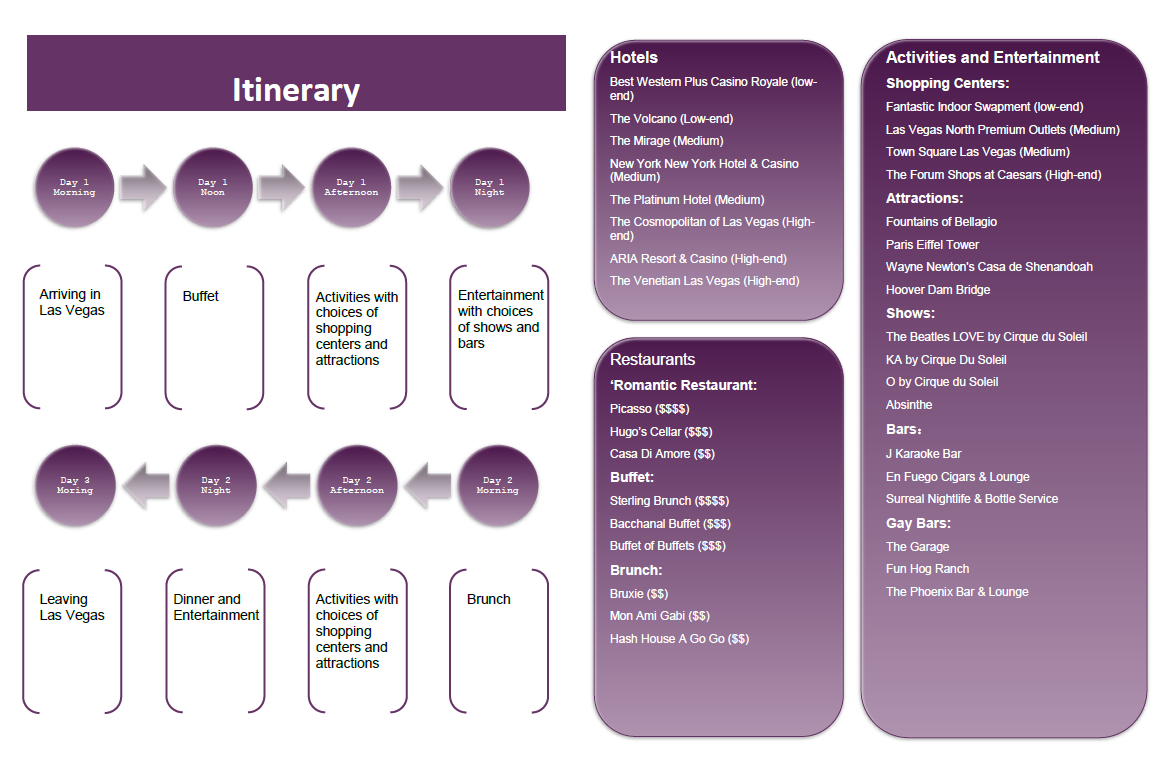

### 3.2 Map

In [106]:
import gmplot

In [116]:
gmap = gmplot.GoogleMapPlotter.from_geocode("Las Vegas")
gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"

In [117]:
#Hotels - blue
gmap.scatter(hotel_lats, hotel_lngs, 'blue', size=60)
#Restaurants - red
gmap.scatter(restaurant_lats, restaurant_lngs, 'red', size=60)
#Shopping - purple
gmap.scatter(shopping_lats, shopping_lngs, '#FF00FF', size=60)
#Attraction - green
gmap.scatter(attraction_lats, attraction_lngs, 'green', size=60)
#Show - yellow
gmap.scatter(attraction_lats, attraction_lngs, 'yellow', size=60)
#Bar - pink
gmap.scatter(bar_lats, bar_lngs, 'pink', size=60)
gmap.scatter(gaybar_lats, gaybar_lngs, 'pink', size=60)

In [118]:
gmap.draw('map.html')

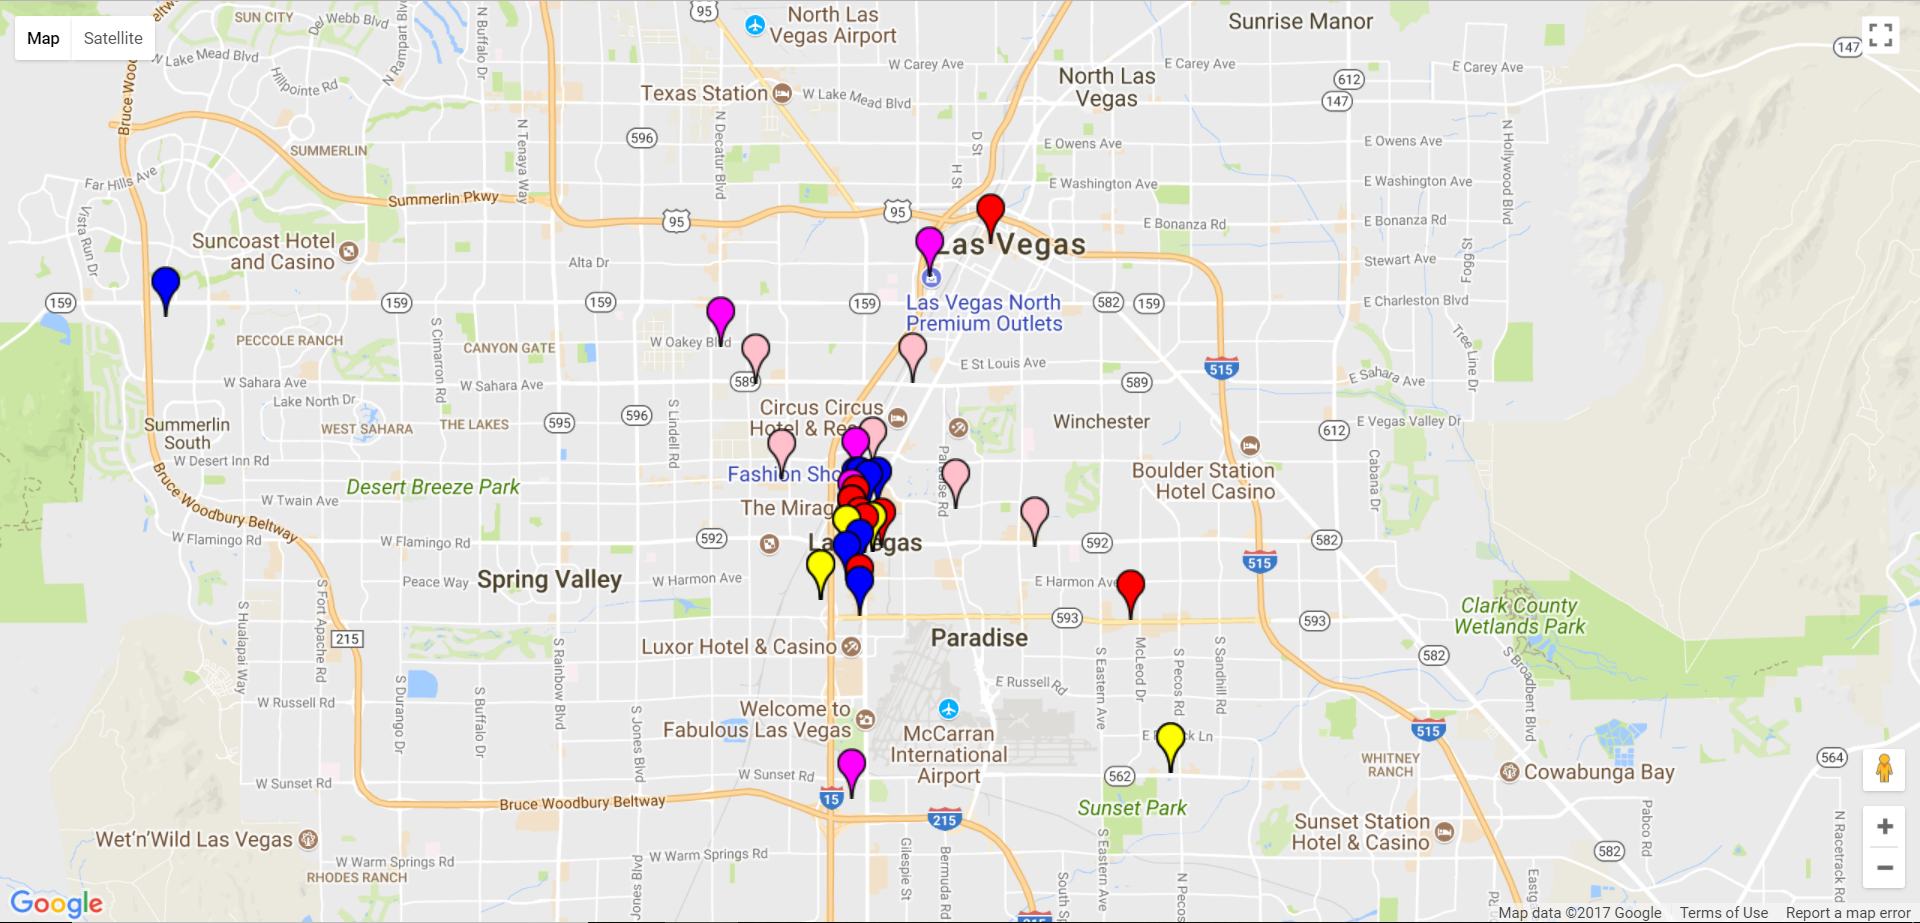